In [303]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [304]:
# Define the Ibuprofen Environment
class IbuprofenEnv(gym.Env):
    def __init__(self):
        super(IbuprofenEnv, self).__init__()
        # Action space: 0 (No dose), 1 (200 mg), ..., 4 (800 mg)
        self.action_space = gym.spaces.Discrete(5)
        # State space: plasma concentration (mg/L)
        self.observation_space = gym.spaces.Box(low=0, high=100, shape=(1,), dtype=np.float32)

        # Pharmacokinetics parameters
        self.therapeutic_range = (10, 50)  # Therapeutic range for the drug (mg/L)
        self.half_life = 2.0  # Plasma half-life in hours
        self.clearance_rate = 0.693 / self.half_life  # First-order decay constant
        self.time_step_hours = 6  # Each time step represents 6 hours

        # Simulation settings
        self.max_steps = 24  # 24 time steps = 6-hour intervals over 6 days
        self.current_step = 0
        self.plasma_concentration = 0.0  # Initial plasma concentration

    def reset(self):
        """
        Reset the environment to its initial state.
        """
        self.current_step = 0
        self.plasma_concentration = 0.0
        return np.array([self.plasma_concentration], dtype=np.float32)

    def step(self, action):
        """
        Take an action (dose) and return the new state, reward, done, and info.
        """
        # Determine dose based on action
        dose_mg = action * 200  # Action index maps to dose in mg
        absorbed = dose_mg / 10  # Assume 10% bioavailability (simplified absorption model)
        self.plasma_concentration += absorbed

        # Clearance via exponential decay (pharmacokinetics)
        self.plasma_concentration *= np.exp(-self.clearance_rate * self.time_step_hours)

        # Calculate reward based on plasma concentration
        if self.therapeutic_range[0] <= self.plasma_concentration <= self.therapeutic_range[1]:
            reward = 10  # Reward for being in the therapeutic range
        elif self.plasma_concentration > 100:  # Toxic concentration
            reward = -20  # Heavy penalty for toxicity
        elif self.plasma_concentration < self.therapeutic_range[0]:
            reward = -5  # Penalty for being subtherapeutic
        else:
            reward = -10  # Penalty for exceeding therapeutic but below toxic levels

        # Update simulation step
        self.current_step += 1
        done = self.current_step >= self.max_steps  # Episode ends after max steps

        return np.array([self.plasma_concentration], dtype=np.float32), reward, done, {}


In [305]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 64),  # Input layer to hidden layer
            nn.ReLU(),                # Activation function
            nn.Linear(64, action_dim), # Hidden layer to output layer
            nn.Softmax(dim=-1)        # Output probabilities for each action
        )

    def forward(self, state):
        """
        Forward pass through the network.
        """
        return self.fc(state)

# Define the Value Network for state value estimation
class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ValueNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 64),  # Input layer to hidden layer
            nn.ReLU(),                # Activation function
            nn.Linear(64, 1)          # Output a single value (state value)
        )

    def forward(self, state):
        """
        Forward pass through the network.
        """
        return self.fc(state)


In [306]:
class PPOAgent:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99, eps_clip=0.2):
        # Initialize policy and value networks
        self.policy = PolicyNetwork(state_dim, action_dim)
        self.value = ValueNetwork(state_dim)
        # Optimizers for policy and value networks
        self.optimizer_policy = optim.Adam(self.policy.parameters(), lr=lr)
        self.optimizer_value = optim.Adam(self.value.parameters(), lr=lr)
        # Discount factor and clipping parameter for PPO
        self.gamma = gamma
        self.eps_clip = eps_clip

    def compute_advantage(self, rewards, values, dones):
        """
        Compute advantage estimates based on rewards, values, and done flags.
        """
        advantage = []
        g_t = 0  # Initialize cumulative return
        for reward, value, done in zip(reversed(rewards), reversed(values), reversed(dones)):
            g_t = reward + self.gamma * g_t * (1 - done)  # Discounted future return
            advantage.insert(0, g_t - value)  # Advantage is return minus value
        return advantage

    def train(self, states, actions, rewards, dones, old_probs):
        """
        Train the policy and value networks using collected trajectories.
        """
        # Convert data to tensors
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)
        old_probs = torch.tensor(old_probs, dtype=torch.float32)

        # Compute state values and advantages
        values = self.value(states).squeeze()
        advantages = self.compute_advantage(rewards, values.detach().numpy(), dones.numpy())
        advantages = torch.tensor(advantages, dtype=torch.float32)

        # Perform multiple PPO updates
        for _ in range(5):
            # Compute new probabilities for the actions taken
            new_probs = self.policy(states).gather(1, actions.unsqueeze(1)).squeeze()
            ratio = (new_probs / old_probs)  # Importance sampling ratio
            clip = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip)
            policy_loss = -torch.min(ratio * advantages, clip * advantages).mean()  # PPO loss

            # Update policy network
            self.optimizer_policy.zero_grad()
            policy_loss.backward()
            self.optimizer_policy.step()

        # Update value network using MSE loss
        value_loss = nn.MSELoss()(self.value(states).squeeze(), rewards)
        self.optimizer_value.zero_grad()
        value_loss.backward()
        self.optimizer_value.step()


In [307]:
env = IbuprofenEnv()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = PPOAgent(state_dim=state_dim, action_dim=action_dim)

# Training loop
episodes = 1000  # Number of training episodes
reward_history = []

for episode in range(episodes):
    state = env.reset()  # Reset environment for each episode
    states, actions, rewards, dones, old_probs = [], [], [], [], []  # Initialize buffers
    total_reward = 0  # Track total reward for the episode

    while True:
        # Select action based on policy
        state_tensor = torch.tensor(state, dtype=torch.float32)
        action_probs = agent.policy(state_tensor).detach().numpy()
        action = np.random.choice(env.action_space.n, p=action_probs)

        # Take action in the environment
        new_state, reward, done, _ = env.step(action)

        # Store transition data
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        dones.append(done)
        old_probs.append(action_probs[action])

        state = new_state  # Update state
        total_reward += reward
        if done:  # End episode if done
            break

    # Train the agent using the collected data
    agent.train(states, actions, rewards, dones, old_probs)
    reward_history.append(total_reward)  # Track episode rewards
    print(f"Episode {episode + 1}: Total Reward = {total_reward}")

Episode 1: Total Reward = -15
Episode 2: Total Reward = 105
Episode 3: Total Reward = 105
Episode 4: Total Reward = 180
Episode 5: Total Reward = 105
Episode 6: Total Reward = 225
Episode 7: Total Reward = 225
Episode 8: Total Reward = 240
Episode 9: Total Reward = 225
Episode 10: Total Reward = 225
Episode 11: Total Reward = 195
Episode 12: Total Reward = 210
Episode 13: Total Reward = 210
Episode 14: Total Reward = 240
Episode 15: Total Reward = 225
Episode 16: Total Reward = 240
Episode 17: Total Reward = 225
Episode 18: Total Reward = 225
Episode 19: Total Reward = 225
Episode 20: Total Reward = 225
Episode 21: Total Reward = 225
Episode 22: Total Reward = 240
Episode 23: Total Reward = 240
Episode 24: Total Reward = 225
Episode 25: Total Reward = 225
Episode 26: Total Reward = 225
Episode 27: Total Reward = 225
Episode 28: Total Reward = 240
Episode 29: Total Reward = 240
Episode 30: Total Reward = 225
Episode 31: Total Reward = 225
Episode 32: Total Reward = 225
Episode 33: Total

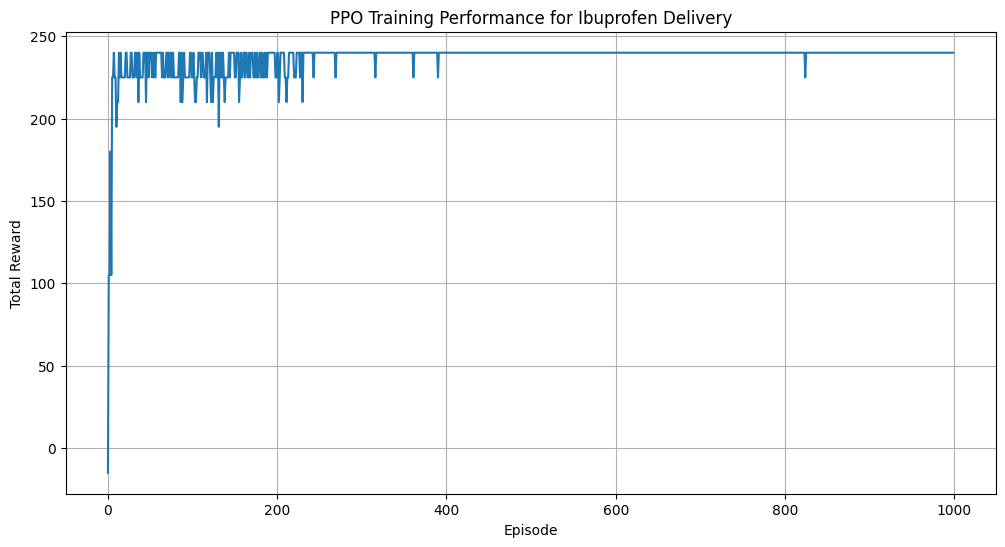

In [312]:
# Plot training performance
plt.figure(figsize=(12, 6))
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('PPO Training Performance for Ibuprofen Delivery')
plt.grid()
plt.show()

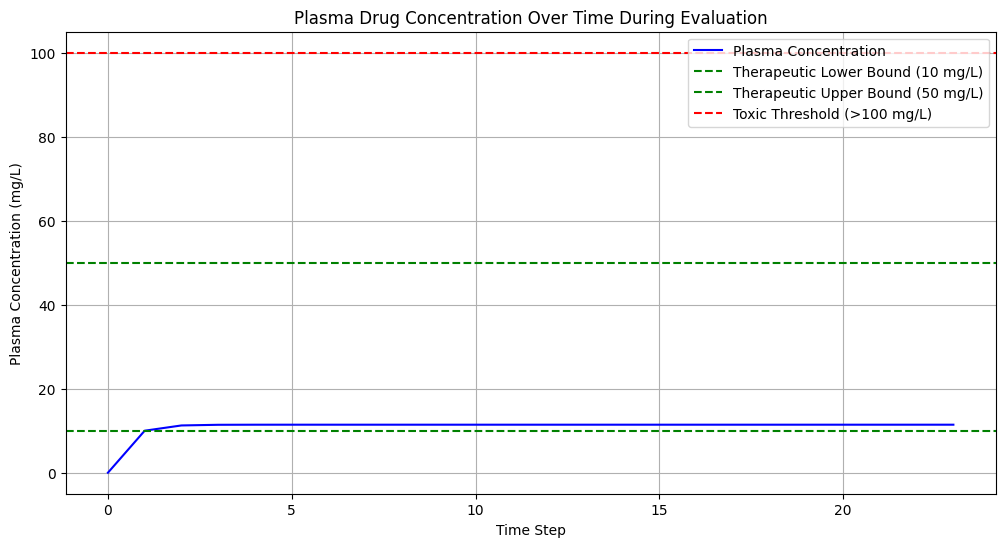

In [313]:
# Evaluation Phase
state_trajectory = []
state = env.reset()
done = False

while not done:
    # Record plasma concentration for each step
    state_trajectory.append(state[0])
    state_tensor = torch.tensor(state, dtype=torch.float32)
    action = agent.policy(state_tensor).argmax().item()  # Greedy action selection
    state, reward, done, _ = env.step(action)

# Plot plasma concentration over time
plt.figure(figsize=(12, 6))
plt.plot(range(len(state_trajectory)), state_trajectory, label='Plasma Concentration', color='b')
plt.axhline(y=10, color='g', linestyle='--', label='Therapeutic Lower Bound (10 mg/L)')
plt.axhline(y=50, color='g', linestyle='--', label='Therapeutic Upper Bound (50 mg/L)')
plt.axhline(y=100, color='r', linestyle='--', label='Toxic Threshold (>100 mg/L)')
plt.xlabel('Time Step')
plt.ylabel('Plasma Concentration (mg/L)')
plt.title('Plasma Drug Concentration Over Time During Evaluation')
plt.legend()
plt.grid()
plt.show()